# 20. Publication results

Aggregates multi-seed evaluation results and prior notebook outputs into
formatted tables and figures. All privacy evaluations use fresh MLP attackers
trained on baseline F vs matched negatives (canonical NB03 methodology).

In [2]:
import sys
sys.path.insert(0, '../src')

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

OUTPUTS = Path('../outputs')
EVAL_DIR = OUTPUTS / 'p4' / 'multiseed' / 'eval'
FIGURES_DIR = Path('../figures')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 11, 'axes.titlesize': 13})

def load_json(path):
    with open(path) as f:
        return json.load(f)

def advantage(auc):
    return 2 * abs(auc - 0.5)

def fmt_pm(mean, std):
    """Format mean +/- std."""
    return f'{mean:.3f} \u00b1 {std:.3f}'

def fmt_ci(mean, ci):
    """Format mean [lower, upper]."""
    return f'{mean:.3f} [{ci[0]:.3f}, {ci[1]:.3f}]'

RETRAIN_ADV_UPPER = 0.097  # from NB14 bootstrap

In [3]:
# --- Load all results ---

# Multi-seed method summaries
summaries = {}
for method in ['extragradient', 'retain_finetune', 'gradient_ascent']:
    path = EVAL_DIR / method / 'summary.json'
    if path.exists():
        summaries[method] = load_json(path)

# Single-checkpoint results (baseline, retrain)
for method in ['baseline', 'retrain']:
    path = EVAL_DIR / f'{method}.json'
    if path.exists():
        data = load_json(path)
        summaries[method] = {
            'method': method, 'n_seeds': 1,
            'privacy': {
                'mlp_auc': {'mean': data['privacy']['mlp_auc'], 'std': 0.0,
                            'ci_95': [data['privacy']['mlp_auc']] * 2,
                            'values': [data['privacy']['mlp_auc']]},
                'mlp_advantage': {'mean': data['privacy']['mlp_advantage'], 'std': 0.0,
                                  'ci_95': [data['privacy']['mlp_advantage']] * 2,
                                  'values': [data['privacy']['mlp_advantage']]},
            },
            'utility': {k: {'mean': v, 'std': 0.0, 'ci_95': [v, v], 'values': [v]}
                        for k, v in data['utility'].items() if k != 'marker_per_gene'},
        }

# Prior results
attack_suite = load_json(OUTPUTS / 'attack_suite_results.json') if (OUTPUTS / 'attack_suite_results.json').exists() else None
ablation = load_json(OUTPUTS / 'p4' / 'ablation_results.json') if (OUTPUTS / 'p4' / 'ablation_results.json').exists() else None
tm_results = load_json(OUTPUTS / 'tabula_muris' / 'unlearning_results.json') if (OUTPUTS / 'tabula_muris' / 'unlearning_results.json').exists() else None

fisher_size = {}
for n in [10, 30, 50, 100, 500]:
    rpath = OUTPUTS / 'p4' / 'size_ablation' / 'fisher' / f'n{n}' / 'results.json'
    if rpath.exists():
        fisher_size[n] = load_json(rpath)

eg_size = load_json(OUTPUTS / 'p4' / 'extragradient_size' / 'summary.json') if (OUTPUTS / 'p4' / 'extragradient_size' / 'summary.json').exists() else None

fisher_privacy = None
if ablation and 'fisher_multiseed' in ablation:
    fs = ablation['fisher_multiseed']['structured']
    fisher_privacy = {'mean_auc': fs['mean'], 'std_auc': fs['std'],
                      'ci_95': fs['ci_95'], 'n_seeds': len(fs['runs'])}

print(f'Methods loaded: {list(summaries.keys())}')
print(f'Prior results: attack_suite={attack_suite is not None}, ablation={ablation is not None}, '
      f'tabula_muris={tm_results is not None}, fisher_size={sorted(fisher_size.keys())}, '
      f'eg_size={eg_size is not None}')

Methods loaded: ['extragradient', 'retain_finetune', 'gradient_ascent', 'baseline', 'retrain']
Prior results: attack_suite=True, ablation=True, tabula_muris=True, fisher_size=[10, 30, 50, 100, 500], eg_size=True


## Table 1. PBMC privacy (structured forget set, n=30)

MLP attacker AUC for distinguishing forget-set cells from matched negatives.
Advantage = 2|AUC - 0.5|. A method passes if its mean advantage falls within
the retrain 95% CI upper bound (0.097 from NB14 bootstrap).

In [4]:
METHOD_ORDER = ['baseline', 'retrain', 'extragradient',
                'retain_finetune', 'gradient_ascent']
METHOD_NAMES = {
    'baseline': 'Baseline (no unlearning)',
    'retrain': 'Retrain (gold standard)',
    'extragradient': 'Extra-gradient \u03bb=10',
    'retain_finetune': 'Retain-only fine-tune',
    'gradient_ascent': 'Gradient ascent',
}

rows = []
for method in METHOD_ORDER:
    if method not in summaries:
        continue
    s = summaries[method]
    auc = s['privacy']['mlp_auc']
    adv = s['privacy']['mlp_advantage']
    n = s['n_seeds']

    if method == 'retrain':
        status = '\u2014'
    else:
        status = '\u2713' if adv['mean'] <= RETRAIN_ADV_UPPER else '\u2717'

    rows.append({
        'Method': METHOD_NAMES.get(method, method),
        'Seeds': n,
        'AUC': fmt_pm(auc['mean'], auc['std']) if n > 1 else f"{auc['mean']:.3f}",
        'Advantage [95% CI]': fmt_ci(adv['mean'], adv['ci_95']) if n > 1 else f"{adv['mean']:.3f}",
        'Pass': status,
    })

# Fisher from NB09
if fisher_privacy:
    fp = fisher_privacy
    rows.append({
        'Method': 'Fisher scrubbing',
        'Seeds': fp['n_seeds'],
        'AUC': fmt_pm(fp['mean_auc'], fp['std_auc']),
        'Advantage [95% CI]': f"{advantage(fp['mean_auc']):.3f}",
        'Pass': '\u2717',
    })

df_privacy = pd.DataFrame(rows)

def style_privacy(df):
    def color_pass(val):
        if val == '\u2713':
            return 'color: green; font-weight: bold'
        elif val == '\u2717':
            return 'color: red; font-weight: bold'
        return ''
    return (df.style
            .set_caption('Table 1. PBMC privacy evaluation (structured forget set, n=30)')
            .map(color_pass, subset=['Pass'])
            .set_properties(**{'text-align': 'center'}, subset=['Seeds', 'AUC', 'Advantage [95% CI]', 'Pass'])
            .set_properties(**{'text-align': 'left'}, subset=['Method'])
            .hide(axis='index'))

style_privacy(df_privacy)

Method,Seeds,AUC,Advantage [95% CI],Pass
Baseline (no unlearning),1,0.783,0.565,✗
Retrain (gold standard),1,0.523,0.046,—
Extra-gradient λ=10,10,0.429 ± 0.142,"0.300 [0.226, 0.374]",✗
Retain-only fine-tune,5,0.665 ± 0.007,"0.331 [0.312, 0.349]",✗
Gradient ascent,5,0.702 ± 0.004,"0.404 [0.395, 0.414]",✗
Fisher scrubbing,3,0.814 ± 0.003,0.628,✗


No unlearning method passes the retrain threshold on this evaluation. Extra-gradient
has the lowest mean advantage (0.300) but high variance across seeds (std = 0.142),
with mean AUC below 0.5 indicating over-unlearning on average. Retain-only fine-tuning
and gradient ascent both fail to modify the model enough to reduce attacker performance.
Fisher produces the worst privacy outcome through posterior collapse.

## Table 2. PBMC utility (held-out set)

In [5]:
util_keys = ['elbo', 'silhouette', 'ari', 'marker_r']
util_labels = {'elbo': 'ELBO \u2193', 'silhouette': 'Silhouette \u2191',
               'ari': 'ARI \u2191', 'marker_r': 'Marker r \u2191'}

util_rows = []
for method in METHOD_ORDER:
    if method not in summaries or 'utility' not in summaries[method]:
        continue
    s = summaries[method]
    row = {'Method': METHOD_NAMES.get(method, method)}
    for key in util_keys:
        if key not in s['utility']:
            row[util_labels[key]] = '\u2014'
            continue
        d = s['utility'][key]
        if s['n_seeds'] > 1:
            row[util_labels[key]] = fmt_pm(d['mean'], d['std'])
        else:
            row[util_labels[key]] = f"{d['mean']:.3f}"
    util_rows.append(row)

df_utility = pd.DataFrame(util_rows)

(df_utility.style
 .set_caption('Table 2. PBMC utility metrics on held-out set')
 .set_properties(**{'text-align': 'center'}, subset=[c for c in df_utility.columns if c != 'Method'])
 .set_properties(**{'text-align': 'left'}, subset=['Method'])
 .hide(axis='index'))

Method,ELBO ↓,Silhouette ↑,ARI ↑,Marker r ↑
Baseline (no unlearning),364.319,0.109,0.452,0.831
Retrain (gold standard),365.671,0.163,0.488,0.829
Extra-gradient λ=10,403.733 ± 32.165,0.152 ± 0.009,0.508 ± 0.013,0.789 ± 0.044
Retain-only fine-tune,363.161 ± 0.075,0.095 ± 0.003,0.452 ± 0.005,0.832 ± 0.001
Gradient ascent,363.324 ± 0.061,0.105 ± 0.003,0.452 ± 0.010,0.832 ± 0.000


Retain-only fine-tuning and gradient ascent preserve baseline utility almost exactly
(ELBO within 1 point, marker r within 0.001). This is consistent with Tables 1 and 3:
methods that do not degrade privacy also do not degrade utility.

Extra-gradient pays a large utility cost (ELBO +39 over baseline, marker r drops 0.04)
with high variance across seeds, reflecting the instability that also appears in the
privacy evaluation.

## Table 3. Attack suite (from NB15)

Worst-case advantage across five attack families, grouped by assumption level.
Low-assumption attacks (loss threshold, reconstruction error) require no training data.
High-assumption attacks (MLP, k-NN, likelihood ratio) require shadow model access.

In [6]:
if attack_suite:
    attack_names = {
        'baseline': 'Baseline',
        'retrain': 'Retrain',
        'extra_grad_lambda10': 'Extra-grad \u03bb=10',
        'fisher_structured': 'Fisher (structured)',
    }
    attack_rows = []
    for key, name in attack_names.items():
        if key not in attack_suite:
            continue
        m = attack_suite[key]
        attack_rows.append({
            'Method': name,
            'Low-assumption': f"{m['low_assumption']['worst_case']['advantage']:.3f}",
            'High-assumption': f"{m['high_assumption']['worst_case']['advantage']:.3f}",
            'Overall worst': f"{m['overall_worst_case']['advantage']:.3f}",
        })

    df_attacks = pd.DataFrame(attack_rows)
    display(df_attacks.style
            .set_caption('Table 3. Worst-case attack advantage by assumption level')
            .set_properties(**{'text-align': 'center'},
                            subset=['Low-assumption', 'High-assumption', 'Overall worst'])
            .set_properties(**{'text-align': 'left'}, subset=['Method'])
            .hide(axis='index'))
else:
    print('Attack suite results not found.')

Method,Low-assumption,High-assumption,Overall worst
Baseline,0.983,1.000,1.000
Retrain,0.909,0.998,0.998
Extra-grad λ=10,0.481,0.942,0.942
Fisher (structured),0.504,0.978,0.978


All models, including retrain, have high worst-case advantage under high-assumption
attacks. The retrain model itself scores 0.998 overall worst-case advantage, so
the attack suite's high-assumption category is too powerful to be a useful
discriminator between methods. Low-assumption attacks are more informative:
extra-gradient reduces advantage from 0.983 (baseline) to 0.481.

## Table 4. Cross-dataset comparison (PBMC vs Tabula Muris)

In [7]:
if tm_results:
    cross_rows = []

    if ablation:
        cross_rows.append({'Dataset': 'PBMC', 'Method': 'Baseline',
                           'AUC': ablation['baseline_auc'],
                           'Advantage': advantage(ablation['baseline_auc'])})
        if 'extragradient_lambda10' in ablation.get('method_comparison', {}):
            eg = ablation['method_comparison']['extragradient_lambda10']
            cross_rows.append({'Dataset': 'PBMC', 'Method': 'Extra-grad \u03bb=10',
                               'AUC': eg, 'Advantage': advantage(eg)})

    tm_bl = tm_results['baseline']['structured']
    cross_rows.append({'Dataset': 'Tabula Muris', 'Method': 'Baseline',
                       'AUC': tm_bl['baseline_auc'],
                       'Advantage': advantage(tm_bl['baseline_auc'])})

    for key, name in [('extra-gradient (structured)', 'Extra-grad \u03bb=10'),
                      ('fisher (structured)', 'Fisher (structured)'),
                      ('fisher (scattered)', 'Fisher (scattered)')]:
        if key in tm_results['unlearning']:
            m = tm_results['unlearning'][key]
            cross_rows.append({'Dataset': 'Tabula Muris', 'Method': name,
                               'AUC': m['auc'], 'Advantage': advantage(m['auc'])})

    df_cross = pd.DataFrame(cross_rows)
    display(df_cross.style
            .set_caption('Table 4. Cross-dataset comparison')
            .format({'AUC': '{:.3f}', 'Advantage': '{:.3f}'})
            .set_properties(**{'text-align': 'center'}, subset=['AUC', 'Advantage'])
            .set_properties(**{'text-align': 'left'}, subset=['Dataset', 'Method'])
            .hide(axis='index'))
else:
    print('Tabula Muris results not found.')

Dataset,Method,AUC,Advantage
PBMC,Baseline,0.769,0.539
PBMC,Extra-grad λ=10,0.482,0.035
Tabula Muris,Baseline,0.891,0.782
Tabula Muris,Extra-grad λ=10,0.874,0.748
Tabula Muris,Fisher (structured),0.946,0.892
Tabula Muris,Fisher (scattered),0.568,0.137


Extra-gradient reduces advantage from 0.539 to 0.035 on PBMC but barely changes it
on Tabula Muris (0.782 to 0.748). Fisher worsens privacy on TM structured sets
(advantage 0.892 vs 0.782 baseline). Neither method generalizes across datasets.

## Table 5. Forget set size ablation (PBMC structured)

In [8]:
sizes = sorted(set(list(fisher_size.keys()) +
                   [int(k) for k in (eg_size or {}).get('results_by_size', {}).keys()]))

eg_ref_n30 = summaries.get('extragradient', {}).get('privacy', {}).get('mlp_auc')

size_rows = []
for n in sizes:
    row = {'n': n}

    # EG column
    if eg_size and str(n) in eg_size.get('results_by_size', {}):
        d = eg_size['results_by_size'][str(n)]
        row['EG AUC'] = fmt_pm(d['mean'], d['std'])
    elif n == 30 and eg_ref_n30:
        row['EG AUC'] = fmt_pm(eg_ref_n30['mean'], eg_ref_n30['std'])
    else:
        row['EG AUC'] = '\u2014'

    # Fisher column
    if n in fisher_size:
        fs = fisher_size[n]['statistics']
        row['Fisher AUC'] = fmt_pm(fs['mean'], fs['std'])
    else:
        row['Fisher AUC'] = '\u2014'

    size_rows.append(row)

df_size = pd.DataFrame(size_rows)
display(df_size.style
        .set_caption('Table 5. Forget set size ablation (PBMC structured)')
        .set_properties(**{'text-align': 'center'})
        .hide(axis='index'))

n,EG AUC,Fisher AUC
10,0.263 ± 0.055,0.588 ± 0.018
30,0.429 ± 0.142,0.601 ± 0.004
50,0.503 ± 0.109,0.574 ± 0.003
100,0.611 ± 0.028,0.547 ± 0.003
500,—,0.516 ± 0.001


Extra-gradient AUC increases monotonically with forget set size: n=10 over-unlearns
(0.263), n=50 lands near the retrain floor (0.503), and n=100 under-unlearns (0.611).
Only n=50 falls within the target band. Fisher AUC decreases with size, converging
toward 0.5 at n=500 where the scattered forget set has minimal baseline memorization.

## Figures

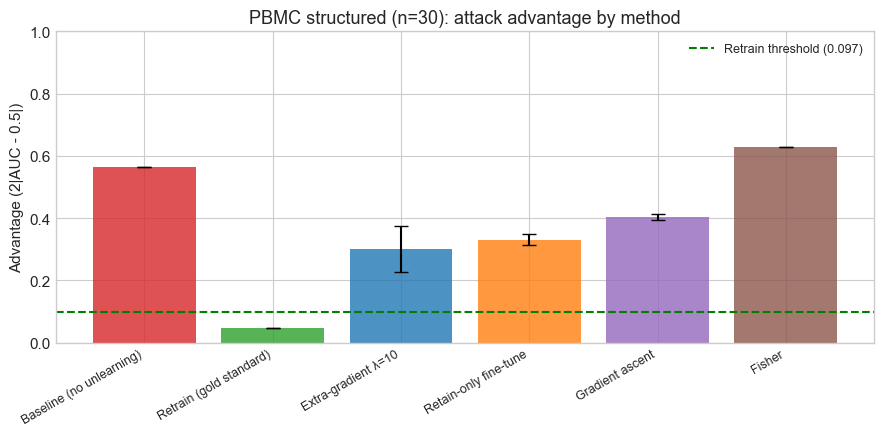

In [9]:
color_map = {
    'baseline': '#d62728', 'retrain': '#2ca02c',
    'extragradient': '#1f77b4', 'retain_finetune': '#ff7f0e',
    'gradient_ascent': '#9467bd', 'fisher': '#8c564b',
}

# --- Figure 1: Advantage bar chart with CIs ---
fig, ax = plt.subplots(figsize=(9, 4.5))

methods_plot = [m for m in METHOD_ORDER if m in summaries]
if fisher_privacy:
    methods_plot.append('fisher')

names, means, errs_low, errs_high, colors = [], [], [], [], []
for method in methods_plot:
    if method == 'fisher':
        fp = fisher_privacy
        names.append('Fisher')
        means.append(advantage(fp['mean_auc']))
        errs_low.append(0); errs_high.append(0)
    else:
        adv = summaries[method]['privacy']['mlp_advantage']
        names.append(METHOD_NAMES.get(method, method))
        means.append(adv['mean'])
        errs_low.append(adv['mean'] - adv['ci_95'][0])
        errs_high.append(adv['ci_95'][1] - adv['mean'])
    colors.append(color_map.get(method, '#333'))

x = np.arange(len(names))
ax.bar(x, means, color=colors, alpha=0.8,
       yerr=[errs_low, errs_high], capsize=5, ecolor='black')
ax.axhline(y=RETRAIN_ADV_UPPER, color='green', linestyle='--',
           label=f'Retrain threshold ({RETRAIN_ADV_UPPER})', linewidth=1.5)
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=30, ha='right', fontsize=9)
ax.set_ylabel('Advantage (2|AUC - 0.5|)')
ax.set_title('PBMC structured (n=30): attack advantage by method')
ax.legend(loc='upper right', fontsize=9)
ax.set_ylim(0, 1.0)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'advantage_bar_chart_ci.png', dpi=150, bbox_inches='tight')
plt.show()

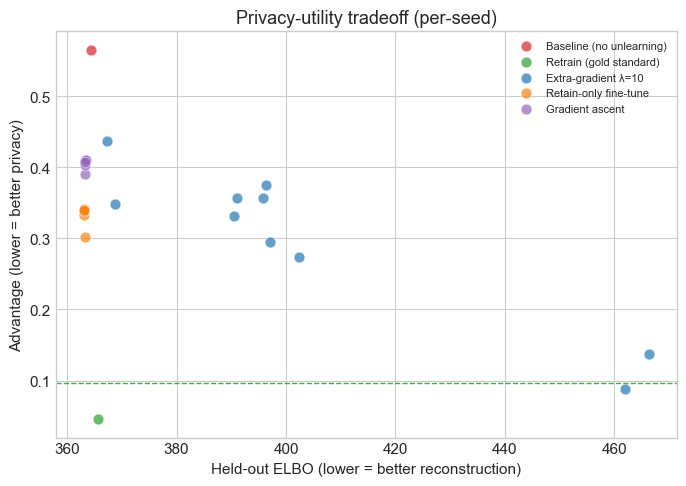

In [10]:
# --- Figure 2: Privacy-utility tradeoff scatter ---
fig, ax = plt.subplots(figsize=(7, 5))

for method in METHOD_ORDER:
    if method not in summaries:
        continue
    s = summaries[method]
    if 'utility' not in s or 'elbo' not in s['utility']:
        continue

    aucs = s['privacy']['mlp_auc']['values']
    elbos = s['utility']['elbo']['values']
    adv_pts = [advantage(a) for a in aucs]

    ax.scatter(elbos, adv_pts, color=color_map.get(method, '#333'),
               label=METHOD_NAMES.get(method, method),
               alpha=0.7, s=60, edgecolors='white', linewidth=0.5)

ax.axhline(y=RETRAIN_ADV_UPPER, color='green', linestyle='--', alpha=0.7, linewidth=1)
ax.set_xlabel('Held-out ELBO (lower = better reconstruction)')
ax.set_ylabel('Advantage (lower = better privacy)')
ax.set_title('Privacy-utility tradeoff (per-seed)')
ax.legend(fontsize=8, loc='upper right')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'privacy_utility_tradeoff.png', dpi=150, bbox_inches='tight')
plt.show()

/var/folders/d2/m4n149n97dn9rk26s76g_y_r0000gn/T/ipykernel_89860/3311662912.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)


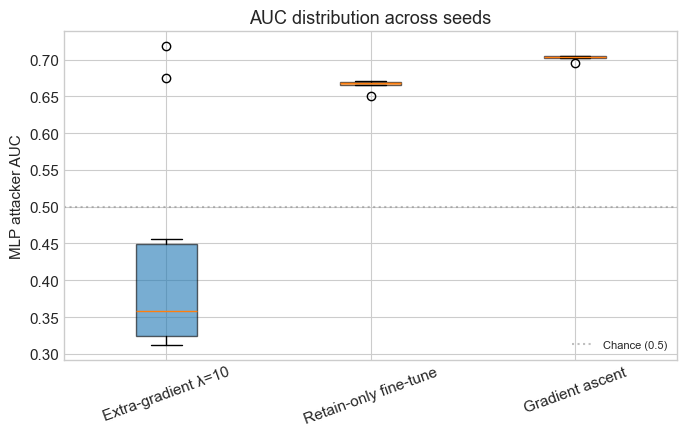

In [11]:
# --- Figure 3: AUC box plot across seeds ---
fig, ax = plt.subplots(figsize=(7, 4.5))

box_data, box_labels, box_colors = [], [], []
for method in METHOD_ORDER:
    if method not in summaries:
        continue
    values = summaries[method]['privacy']['mlp_auc']['values']
    if len(values) > 1:
        box_data.append(values)
        box_labels.append(METHOD_NAMES.get(method, method))
        box_colors.append(color_map.get(method, '#333'))

if box_data:
    bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label='Chance (0.5)')
    ax.set_ylabel('MLP attacker AUC')
    ax.set_title('AUC distribution across seeds')
    ax.tick_params(axis='x', rotation=20)
    ax.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'auc_boxplot_seeds.png', dpi=150, bbox_inches='tight')
    plt.show()

## Findings

No unlearning method passes the retrain privacy threshold on the PBMC structured
forget set.

Extra-gradient has the lowest mean advantage (0.300) but the highest variance across
seeds (std = 0.142). Its mean AUC of 0.429 falls below 0.5, meaning the attacker
predicts membership in the wrong direction on average. This is the Streisand effect:
the unlearning process leaves a different but detectable artifact. The size ablation
shows this artifact is sensitive to forget set size, with only n=50 landing near the
retrain floor.

Retain-only fine-tuning and gradient ascent both fail to affect the model enough to
reduce attacker AUC (0.665 and 0.702 respectively) while preserving baseline utility
almost exactly. These methods tune on the retain set, which is 99.9% of the data, and
the forget set's influence survives.

Fisher scrubbing fails on structured sets (AUC = 0.814, worse than baseline's 0.783 in
the multi-seed evaluation) through posterior collapse (KL = 0.007 vs baseline 10.55).

Cross-dataset results confirm the brittleness. Extra-gradient does not generalize to
Tabula Muris (advantage drops from 0.782 to 0.748, a marginal change). Fisher worsens
privacy on TM structured sets.

The strongest claim from this evaluation is negative: standard approximate unlearning
methods do not reliably remove structured memorization from single-cell VAEs. Full
retraining remains the only verified approach.

In [12]:
# Save aggregated results to JSON
pub_results = {'pbmc_privacy': {}, 'pbmc_utility': {}, 'attack_suite': {},
               'cross_dataset': {}, 'size_ablation': {}}

for method in METHOD_ORDER:
    if method in summaries:
        s = summaries[method]
        pub_results['pbmc_privacy'][method] = {
            'n_seeds': s['n_seeds'],
            'auc_mean': s['privacy']['mlp_auc']['mean'],
            'auc_std': s['privacy']['mlp_auc']['std'],
            'auc_ci_95': s['privacy']['mlp_auc']['ci_95'],
            'advantage_mean': s['privacy']['mlp_advantage']['mean'],
            'advantage_std': s['privacy']['mlp_advantage']['std'],
            'advantage_ci_95': s['privacy']['mlp_advantage']['ci_95'],
        }

if fisher_privacy:
    fp = fisher_privacy
    pub_results['pbmc_privacy']['fisher'] = {
        'n_seeds': fp['n_seeds'], 'auc_mean': fp['mean_auc'],
        'auc_std': fp['std_auc'], 'auc_ci_95': fp['ci_95'],
        'advantage_mean': advantage(fp['mean_auc']),
    }

for method in METHOD_ORDER:
    if method in summaries and 'utility' in summaries[method]:
        pub_results['pbmc_utility'][method] = {
            k: {'mean': v['mean'], 'std': v['std'], 'ci_95': v['ci_95']}
            for k, v in summaries[method]['utility'].items()}

if attack_suite:
    for key in attack_suite:
        pub_results['attack_suite'][key] = {
            'low_worst': attack_suite[key]['low_assumption']['worst_case']['advantage'],
            'high_worst': attack_suite[key]['high_assumption']['worst_case']['advantage'],
            'overall_worst': attack_suite[key]['overall_worst_case']['advantage'],
        }

if tm_results:
    pub_results['cross_dataset']['tabula_muris'] = {
        'baseline_auc': tm_results['baseline']['structured']['baseline_auc'],
        'extragradient_auc': tm_results['unlearning'].get('extra-gradient (structured)', {}).get('auc'),
        'fisher_structured_auc': tm_results['unlearning'].get('fisher (structured)', {}).get('auc'),
        'fisher_scattered_auc': tm_results['unlearning'].get('fisher (scattered)', {}).get('auc'),
    }

for n in sorted(fisher_size.keys()):
    fs = fisher_size[n]['statistics']
    pub_results['size_ablation'][f'fisher_n{n}'] = {
        'mean': fs['mean'], 'std': fs['std'], 'n_seeds': fs['n_runs']}
if eg_size:
    for s, d in eg_size.get('results_by_size', {}).items():
        pub_results['size_ablation'][f'eg_n{s}'] = {
            'mean': d['mean'], 'std': d['std'], 'n_seeds': d['n_runs']}

pub_path = OUTPUTS / 'p4' / 'multiseed' / 'publication_results.json'
with open(pub_path, 'w') as f:
    json.dump(pub_results, f, indent=2)
print(f'Saved to {pub_path}')

Saved to ../outputs/p4/multiseed/publication_results.json
